## Stan (*ang. State*)

**Typ**: behawioralny  
**Zakres**: obiektowy  
**Inna nazwa**: obiekt stanów

<div style="border: solid 1px;padding: 20px;text-align: center">
    Wzorzec <b>stan</b> pozwala obiektowi zmieniać swoje zachowanie w zależności od wewnętrznego stanu. Wygląda to tak, jakby obiekt zmienił swoją klasę.
</div>

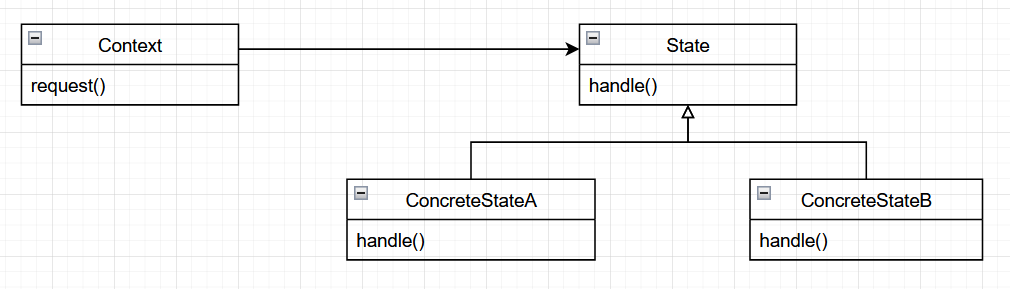

### Problem - zachowanie zależy od stanu

Masz odtwarzacz muzyki. Możesz:
- `play()` - odtwarzaj
- `pause()` - zatrzymaj
- `stop()` - wyłącz

**Ale zachowanie zależy od stanu:**
- `play()` w stanie **Stopped** → zaczyna odtwarzanie
- `play()` w stanie **Playing** → nic nie robi (już gra!)
- `pause()` w stanie **Playing** → pauzuje
- `pause()` w stanie **Stopped** → nic nie robi (nie ma co pauzować!)

### Naiwne podejście - `if/elif` sprawdzające stan

In [ ]:
class MusicPlayer:
    def __init__(self):
        self.state = "stopped"  # Stan jako string
    
    def play(self):
        # ❌ Warunki sprawdzające stan
        if self.state == "stopped":
            print("▶️  Odtwarzam muzykę")
            self.state = "playing"
        elif self.state == "paused":
            print("▶️  Wznawiam odtwarzanie")
            self.state = "playing"
        elif self.state == "playing":
            print("▶️  Już odtwarzam!")
    
    def pause(self):
        if self.state == "playing":
            print("⏸️  Pauzuję")
            self.state = "paused"
        elif self.state == "paused":
            print("⏸️  Już zapauzowane!")
        elif self.state == "stopped":
            print("⏸️  Nie ma czego pauzować")
    
    def stop(self):
        if self.state == "playing" or self.state == "paused":
            print("⏹️  Zatrzymuję")
            self.state = "stopped"
        elif self.state == "stopped":
            print("⏹️  Już zatrzymane!")

In [ ]:
player = MusicPlayer()
player.play()   # Stopped → Playing
player.pause()  # Playing → Paused
player.play()   # Paused → Playing
player.stop()   # Playing → Stopped

**Problemy:**
- ❌ **Każda metoda pełna `if/elif`** sprawdzających stan
- ❌ Dodanie nowego stanu (np. `"buffering"`) → **zmiana wszystkich metod**!
- ❌ Dodanie nowej akcji (np. `next()`) → **kolejne `if/elif` we wszystkich stanach**
- ❌ **Trudne w utrzymaniu** - logika rozrzucona
- ❌ **Łatwo o błąd** - zapomnisz o jednym warunku

### Rozwiązanie - wzorzec Stan

**Idea:** Każdy stan to **osobna klasa**. Polimorfizm zamiast `if/elif`.

### Krok 1: Interfejs stanu

In [ ]:
from abc import ABC, abstractmethod

class State(ABC):
    """Interfejs dla wszystkich stanów"""
    
    @abstractmethod
    def play(self, player):
        pass
    
    @abstractmethod
    def pause(self, player):
        pass
    
    @abstractmethod
    def stop(self, player):
        pass

### Krok 2: Konkretne stany

In [ ]:
class StoppedState(State):
    """Stan: zatrzymany"""
    
    def play(self, player):
        print("▶️  Odtwarzam muzykę")
        player.set_state(PlayingState())  # Zmiana stanu!
    
    def pause(self, player):
        print("⏸️  Nie ma czego pauzować")
    
    def stop(self, player):
        print("⏹️  Już zatrzymane!")


class PlayingState(State):
    """Stan: odtwarzanie"""
    
    def play(self, player):
        print("▶️  Już odtwarzam!")
    
    def pause(self, player):
        print("⏸️  Pauzuję")
        player.set_state(PausedState())  # Zmiana stanu!
    
    def stop(self, player):
        print("⏹️  Zatrzymuję")
        player.set_state(StoppedState())  # Zmiana stanu!


class PausedState(State):
    """Stan: zapauzowany"""
    
    def play(self, player):
        print("▶️  Wznawiam odtwarzanie")
        player.set_state(PlayingState())  # Zmiana stanu!
    
    def pause(self, player):
        print("⏸️  Już zapauzowane!")
    
    def stop(self, player):
        print("⏹️  Zatrzymuję")
        player.set_state(StoppedState())  # Zmiana stanu!

**Kluczowa zmiana:**
- Każdy stan wie **co zrobić** dla każdej akcji
- Stan sam **zmienia się** na inny stan (wywołuje `player.set_state()`)
- **Brak `if/elif`** - polimorfizm!

### Krok 3: Kontekst (odtwarzacz)

In [ ]:
class MusicPlayer:
    """Kontekst - deleguje do aktualnego stanu"""
    
    def __init__(self):
        self._state = StoppedState()  # Stan początkowy
    
    def set_state(self, state: State):
        """Zmiana stanu"""
        self._state = state
    
    def play(self):
        # ✅ Deleguj do stanu - BEZ if/elif!
        self._state.play(self)
    
    def pause(self):
        self._state.pause(self)
    
    def stop(self):
        self._state.stop(self)

**Kontekst:**
- Przechowuje **aktualny stan**
- **Deleguje** wszystkie metody do stanu
- **Nie sprawdza** co to za stan - polimorfizm!

### Krok 4: Użycie - bez `if/elif`

In [ ]:
player = MusicPlayer()

player.play()   # StoppedState.play() → PlayingState
player.pause()  # PlayingState.pause() → PausedState
player.play()   # PausedState.play() → PlayingState
player.stop()   # PlayingState.stop() → StoppedState

print("\nNieprawidłowe akcje:")
player.pause()  # StoppedState.pause() → nic
player.stop()   # StoppedState.stop() → już zatrzymane

**Zalety:**
- ✅ **Brak `if/elif`** - polimorfizm
- ✅ Nowy stan? **1 nowa klasa** (nie zmieniasz istniejących!)
- ✅ Nowa akcja? **Dodaj metodę do interfejsu** (przynajmniej nie zapomnisz dodać we wszyskich miejscach, kompilator wymusi implementację)
- ✅ **Logika zgrupowana** - każdy stan w osobnej klasie

Wady:
- ❌ Trudno dodać nową akcję (trzeba modyfikować wszystkie stany)
- ❌ Wiele małych klas (może być przesadzone dla prostych przypadków)
- ❌ Naruszenie Open/Closed przy dodawaniu akcji

# Diagram stanów

```
                    ╔═══════════════╗
                    ║   ● START     ║
                    ╚═══════╤═══════╝
                            │
                            │ init
                            ▼
                    ┏━━━━━━━━━━━━━━━┓
                ┌──▶┃    STOPPED    ┃◀──┐
                │   ┗━━━━━━━┯━━━━━━━┛   │
                │           │           │
                │ stop      │ play      │ stop
                │           ▼           │
                │   ┏━━━━━━━━━━━━━━━┓   │
                │   ┃    PLAYING    ┃───┘
                │   ┗━━━┯━━━━━━┯━━━━┛
                │       │      │
                │ pause │      └──────────┐
                │       ▼                 │ play
                │   ┏━━━━━━━━━━━━━━━┓     │ (wznowienie)
                └───┃    PAUSED     ┃─────┘
                    ┗━━━━━━━━━━━━━━━┛
```

## Legenda:

- `●` - stan początkowy
- `┏━━━┓` - stan
- `→` - przejście
- Etykiety na strzałkach - akcje/zdarzenia

## Przejścia:

| Ze stanu | Akcja | Do stanu |
|----------|-------|----------|
| START | init | STOPPED |
| STOPPED | play | PLAYING |
| PLAYING | pause | PAUSED |
| PLAYING | stop | STOPPED |
| PAUSED | play | PLAYING |
| PAUSED | stop | STOPPED |

## Zachowania samopętli (ignorowane akcje):

- STOPPED + stop → STOPPED (brak zmiany)
- STOPPED + pause → STOPPED (brak zmiany)
- PLAYING + play → PLAYING (brak zmiany)
- PAUSED + pause → PAUSED (brak zmiany)

## Przykład 2 - zamówienie w sklepie

In [ ]:
from abc import ABC, abstractmethod

# ════════════════════════════════════════════════════════════
# Interfejs stanu
# ════════════════════════════════════════════════════════════
class OrderState(ABC):
    @abstractmethod
    def pay(self, order):
        pass
    
    @abstractmethod
    def ship(self, order):
        pass
    
    @abstractmethod
    def deliver(self, order):
        pass
    
    @abstractmethod
    def cancel(self, order):
        pass


# ════════════════════════════════════════════════════════════
# Konkretne stany
# ════════════════════════════════════════════════════════════
class NewOrderState(OrderState):
    def pay(self, order):
        print("💳 Płatność przyjęta")
        order.set_state(PaidState())
    
    def ship(self, order):
        print("❌ Nie można wysłać - brak płatności!")
    
    def deliver(self, order):
        print("❌ Nie można dostarczyć - brak płatności!")
    
    def cancel(self, order):
        print("🚫 Zamówienie anulowane")
        order.set_state(CancelledState())


class PaidState(OrderState):
    def pay(self, order):
        print("💳 Już opłacone!")
    
    def ship(self, order):
        print("📦 Wysyłam zamówienie")
        order.set_state(ShippedState())
    
    def deliver(self, order):
        print("❌ Nie można dostarczyć - jeszcze nie wysłane!")
    
    def cancel(self, order):
        print("🚫 Anulowanie (zwrot płatności)")
        order.set_state(CancelledState())


class ShippedState(OrderState):
    def pay(self, order):
        print("💳 Już opłacone!")
    
    def ship(self, order):
        print("📦 Już wysłane!")
    
    def deliver(self, order):
        print("✅ Dostarczone!")
        order.set_state(DeliveredState())
    
    def cancel(self, order):
        print("❌ Nie można anulować - już wysłane!")


class DeliveredState(OrderState):
    def pay(self, order):
        print("💳 Już opłacone!")
    
    def ship(self, order):
        print("📦 Już wysłane!")
    
    def deliver(self, order):
        print("✅ Już dostarczone!")
    
    def cancel(self, order):
        print("❌ Nie można anulować - już dostarczone!")


class CancelledState(OrderState):
    def pay(self, order):
        print("❌ Zamówienie anulowane")
    
    def ship(self, order):
        print("❌ Zamówienie anulowane")
    
    def deliver(self, order):
        print("❌ Zamówienie anulowane")
    
    def cancel(self, order):
        print("🚫 Już anulowane!")


# ════════════════════════════════════════════════════════════
# Kontekst
# ════════════════════════════════════════════════════════════
class Order:
    def __init__(self):
        self._state = NewOrderState()
    
    def set_state(self, state: OrderState):
        self._state = state
    
    def pay(self):
        self._state.pay(self)
    
    def ship(self):
        self._state.ship(self)
    
    def deliver(self):
        self._state.deliver(self)
    
    def cancel(self):
        self._state.cancel(self)

In [ ]:
# Prawidłowy proces
print("=== Prawidłowy proces ===")
order = Order()
order.pay()      # New → Paid
order.ship()     # Paid → Shipped
order.deliver()  # Shipped → Delivered

print("\n=== Nieprawidłowe akcje ===")
order2 = Order()
order2.ship()    # New: nie można wysłać bez płatności
order2.deliver() # New: nie można dostarczyć bez płatności

print("\n=== Anulowanie ===")
order3 = Order()
order3.pay()
order3.cancel()  # Paid → Cancelled (zwrot)

**Każdy stan definiuje:**
- Jakie akcje są **dozwolone**
- Jakie akcje są **zabronione**
- Jak **przejść** do następnego stanu

## Struktura wzorca

**Elementy wzorca Stan:**

1. **Context** - `MusicPlayer`, `Order`
   - Przechowuje aktualny stan
   - Deleguje akcje do stanu
   - Udostępnia `set_state()` dla stanów

2. **State** - `State`, `OrderState`
   - Interfejs dla wszystkich stanów
   - Deklaruje metody dla wszystkich akcji

3. **ConcreteState** - `StoppedState`, `PlayingState`, `PausedState`
   - Konkretny stan
   - Implementuje zachowanie dla każdej akcji
   - Zmienia stan kontekstu (`context.set_state()`)

**Kluczowa właściwość:**
> Stan **sam decyduje** jak obsłużyć akcję i na jaki stan przejść

## Kiedy używać wzorca Stan?

Wzorzec Stan stosuj gdy:

1. **Zachowanie obiektu zależy od stanu**
   - Ta sama akcja robi różne rzeczy w różnych stanach

2. **Wiele warunków `if/elif` sprawdzających stan**
   - Każda metoda ma `if state == "x"` lub `elif state == "y"`

3. **Przejścia między stanami są jasno zdefiniowane**
   - Możesz narysować diagram stanów
   - Znasz wszystkie możliwe przejścia

4. **Stany mogą być dodawane/zmieniane**
   - System może ewoluować (nowe stany)

**Przykłady praktyczne:**
- Odtwarzacz multimedialny (playing, paused, stopped)
- Zamówienie w sklepie (new, paid, shipped, delivered)
- Połączenie TCP (closed, listening, established)
- Dokument (draft, review, approved, published)
- Automat do sprzedaży (no coin, has coin, sold out)
- Gra (menu, playing, paused, game over)

## Stan vs Strategia

**Oba wzorce wyglądają podobnie (kompozycja + delegacja), ale:**

| Aspekt | Stan | Strategia |
|--------|------|----------|
| **Cel** | Zmiana zachowania gdy zmienia się stan | Wymienialny algorytm |
| **Zmiana** | Stan **sam się zmienia** | Klient **ustawia** strategię |
| **Zależności** | Stany **znają się** (przejścia) | Strategie **niezależne** |

**Stan:**
```python
player.play()  # StoppedState sam zmienia na PlayingState
# Stan decyduje o przejściu
```

**Strategia:**
```python
sorter.set_strategy(QuickSort())  # Klient wybiera strategię
# Klient decyduje o zmianie
```

## Podsumowanie

Wzorzec Stan:
- ✅ **Eliminuje `if/elif`** sprawdzające stan
- ✅ **Polimorfizm** zamiast warunków
- ✅ **Logika zgrupowana** - każdy stan w osobnej klasie
- ✅ **Łatwe dodawanie** nowych stanów (bez zmiany istniejących)
- ✅ **Open/Closed Principle** - rozszerzanie bez modyfikacji
- ⚠️ **Więcej klas** - każdy stan to osobna klasa
- ⚠️ **Overkill** dla prostych przypadków (2-3 stany, proste zachowanie)

**Kluczowa idea:**
> Zachowanie obiektu zmienia się ze **stanem** → każdy stan to **osobna klasa**

**Struktura:**
- **Context** - deleguje do aktualnego stanu
- **State** - interfejs dla wszystkich stanów
- **ConcreteState** - konkretny stan, zmienia stan kontekstu

**Formuła:**
```python
# Context
class Context:
    def __init__(self):
        self._state = InitialState()
    
    def action(self):
        self._state.handle(self)  # Delegacja

# ConcreteState
class StateA(State):
    def handle(self, context):
        # Logika dla StateA
        context.set_state(StateB())  # Zmiana stanu
```

**Istota wzorca:**
- **Polimorfizm zamiast `if/elif`:** `state.action()` zamiast `if state == "x"`
- **Stan kontroluje przejścia:** Sam decyduje kiedy zmienić stan
- **Zachowanie = Stan:** Ten sam kontekst, różne zachowanie w różnych stanach